In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
np.random.seed(777)
import math
import keras
import keras.backend as K
import h5py
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Activation, merge, Dense, Flatten, Dropout, concatenate
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization, add, GlobalAveragePooling2D
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score
from keras.regularizers import l2
from keras.applications.xception import Xception, preprocess_input
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications import DenseNet201
from keras.applications import DenseNet121

from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Lambda,Concatenate
from keras.layers import SeparableConv2D, AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Add

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

Using TensorFlow backend.


In [3]:
train_dir = 'data/iciar/train/'
test_dir = "data/iciar/test/"

extracted_features_dir = "extracted_features/"
model_name = "iciar_VGG16"

In [4]:
import keras
import tensorflow as tf
import keras.backend as K

print("Keras Version", keras.__version__)
print("tensorflow Version", tf.__version__)
print("dim_ordering:", K.image_dim_ordering())

Keras Version 2.2.4
tensorflow Version 1.10.0
dim_ordering: tf


In [5]:
batch_size = 32
img_height, img_width = 224, 224
input_shape = (img_height, img_width, 3)
epochs = 1000

In [6]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

print("*"*30)
for root,dirs,files in os.walk(test_dir):
    print (root, len(files))

data/iciar/train/ 0
data/iciar/train/carcinoma 2310
data/iciar/train/non-carcinoma 2310
******************************
data/iciar/test/ 0
data/iciar/test/carcinoma 50
data/iciar/test/non-carcinoma 50


In [7]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    validation_split= 0.25,
    zoom_range=0.2,
    shear_range=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'validation',
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 3466 images belonging to 2 classes.
Found 1154 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [8]:
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))

nb_test_samples = len(test_generator.filenames)
predict_size_test = int(math.ceil(nb_test_samples / batch_size))

# nb_test_without_aug_samples = len(test_generator_without_aug.filenames)
# predict_size_test_without_aug = int(math.ceil(nb_test_without_aug_samples / batch_size))

num_classes = len(train_generator.class_indices)

print("nb_train_samples:", nb_train_samples)
print("nb_validation_samples:", nb_validation_samples)
print("\npredict_size_train:", predict_size_train)
print("predict_size_validation:", predict_size_validation)
# print("nb_test_without_aug_samples:", nb_test_without_aug_samples)
# print("predict_size_test_without_aug_samples:", predict_size_test_without_aug)
print("nb_test_samples:", nb_test_samples)
print("predict_size_test:", predict_size_test)

print("\n num_classes:", num_classes)

nb_train_samples: 3466
nb_validation_samples: 1154

predict_size_train: 109
predict_size_validation: 37
nb_test_samples: 100
predict_size_test: 4

 num_classes: 2


In [9]:
# from keras.backend.tensorflow_backend import get_session
# from keras.backend.tensorflow_backend import clear_session
# from keras.backend.tensorflow_backend import set_session

# def reset_keras_tf_session():
#     """
#     this function clears the gpu memory and set the 
#     tf session to not use the whole gpu
#     """
#     sess = get_session()
#     clear_session()
#     sess.close()
#     sess = get_session()

# #     config = tf.ConfigProto()
# #     config.gpu_options.allow_growth = True
# #     set_session(tf.Session(config=config))


# reset_keras_tf_session()

In [10]:
# from keras.applications.mobilenetv2 import MobileNetV2
# from keras.applications.densenet import DenseNet169
# from keras.applications.vgg19 import VGG19
# from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
# from keras.applications.xception import Xception, preprocess_input
# from keras.applications import DenseNet201
# from keras.applications import DenseNet121
# from keras.applications import ResNet50
# from keras.applications.inception_resnet_v2 import InceptionResNetV2
# from keras.applications import NASNetLarge, NASNetMobile
# from keras.applications import MobileNet


In [11]:
input_tensor = Input(shape = input_shape)  
model = VGG16(weights='imagenet', include_top=False, pooling = 'avg', input_tensor=input_tensor)
bottleneck_final_model = model

In [12]:
# for i, layer in enumerate(model.layers):
#     print(i, layer.name)

In [13]:
# c1 = model.layers[9].output 
# c1 = GlobalAveragePooling2D()(c1)       

# c2 = model.layers[55].output
# c2 = GlobalAveragePooling2D()(c2)       

# c3 = model.layers[143].output
# c3 = GlobalAveragePooling2D()(c3)       

# c4 = model.layers[483].output
# c4 = GlobalAveragePooling2D()(c4)

# con = concatenate([c1, c2, c3, c4])

# bottleneck_final_model = Model(inputs=model.input, outputs=con)

In [14]:
# bottleneck_final_model.summary()

In [15]:
bottleneck_features_train = bottleneck_final_model.predict_generator(train_generator, predict_size_train)
np.save(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy', bottleneck_features_train)

In [16]:
bottleneck_features_validation = bottleneck_final_model.predict_generator(validation_generator, predict_size_validation)
np.save(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy', bottleneck_features_validation)

bottleneck_features_test = bottleneck_final_model.predict_generator(test_generator, predict_size_test)
np.save(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy', bottleneck_features_test)

In [17]:
train_data = np.load(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy')
validation_data = np.load(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy')
test_data = np.load(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy')

train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

validation_labels = validation_generator.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

test_labels = test_generator.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [18]:
dropout_rate = 0.4

model = Sequential()
# model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(num_classes, activation=tf.nn.softmax))

adam_opt2=Adam(lr = 0.0001, beta_1=0.6, beta_2=0.9, amsgrad=False)

model.compile(optimizer=adam_opt2, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
                    verbose= 2)

with open(extracted_features_dir+'history_'+model_name+'.txt','w') as f:
    f.write(str(history.history))

# model.save_weights(top_model_weights_path)
# model.save(top_model_path)

Train on 3466 samples, validate on 1154 samples
Epoch 1/1000
 - 1s - loss: 0.7041 - acc: 0.5710 - val_loss: 0.6149 - val_acc: 0.6906
Epoch 2/1000
 - 0s - loss: 0.6193 - acc: 0.6518 - val_loss: 0.5560 - val_acc: 0.7626
Epoch 3/1000
 - 0s - loss: 0.5757 - acc: 0.7080 - val_loss: 0.5295 - val_acc: 0.7660
Epoch 4/1000
 - 0s - loss: 0.5438 - acc: 0.7314 - val_loss: 0.5090 - val_acc: 0.7721
Epoch 5/1000
 - 0s - loss: 0.5220 - acc: 0.7574 - val_loss: 0.4949 - val_acc: 0.7825
Epoch 6/1000
 - 0s - loss: 0.5075 - acc: 0.7585 - val_loss: 0.4843 - val_acc: 0.7816
Epoch 7/1000
 - 0s - loss: 0.4936 - acc: 0.7726 - val_loss: 0.4723 - val_acc: 0.7886
Epoch 8/1000
 - 0s - loss: 0.4801 - acc: 0.7770 - val_loss: 0.4620 - val_acc: 0.7886
Epoch 9/1000
 - 0s - loss: 0.4677 - acc: 0.7931 - val_loss: 0.4521 - val_acc: 0.8016
Epoch 10/1000
 - 0s - loss: 0.4570 - acc: 0.7905 - val_loss: 0.4447 - val_acc: 0.7998
Epoch 11/1000
 - 0s - loss: 0.4504 - acc: 0.8018 - val_loss: 0.4362 - val_acc: 0.8128
Epoch 12/1000
 

Epoch 96/1000
 - 0s - loss: 0.1556 - acc: 0.9440 - val_loss: 0.1824 - val_acc: 0.9307
Epoch 97/1000
 - 0s - loss: 0.1528 - acc: 0.9492 - val_loss: 0.1813 - val_acc: 0.9272
Epoch 98/1000
 - 0s - loss: 0.1530 - acc: 0.9495 - val_loss: 0.1798 - val_acc: 0.9255
Epoch 99/1000
 - 0s - loss: 0.1496 - acc: 0.9443 - val_loss: 0.1811 - val_acc: 0.9289
Epoch 100/1000
 - 0s - loss: 0.1487 - acc: 0.9507 - val_loss: 0.1762 - val_acc: 0.9315
Epoch 101/1000
 - 0s - loss: 0.1460 - acc: 0.9530 - val_loss: 0.1792 - val_acc: 0.9272
Epoch 102/1000
 - 0s - loss: 0.1451 - acc: 0.9495 - val_loss: 0.1773 - val_acc: 0.9350
Epoch 103/1000
 - 0s - loss: 0.1402 - acc: 0.9515 - val_loss: 0.1722 - val_acc: 0.9341
Epoch 104/1000
 - 0s - loss: 0.1378 - acc: 0.9544 - val_loss: 0.1741 - val_acc: 0.9350
Epoch 105/1000
 - 0s - loss: 0.1439 - acc: 0.9535 - val_loss: 0.1696 - val_acc: 0.9341
Epoch 106/1000
 - 0s - loss: 0.1378 - acc: 0.9527 - val_loss: 0.1685 - val_acc: 0.9411
Epoch 107/1000
 - 0s - loss: 0.1357 - acc: 0.95

Epoch 191/1000
 - 0s - loss: 0.0512 - acc: 0.9887 - val_loss: 0.0982 - val_acc: 0.9601
Epoch 192/1000
 - 0s - loss: 0.0531 - acc: 0.9862 - val_loss: 0.1005 - val_acc: 0.9601
Epoch 193/1000
 - 0s - loss: 0.0493 - acc: 0.9885 - val_loss: 0.0918 - val_acc: 0.9619
Epoch 194/1000
 - 0s - loss: 0.0512 - acc: 0.9887 - val_loss: 0.0908 - val_acc: 0.9653
Epoch 195/1000
 - 0s - loss: 0.0510 - acc: 0.9882 - val_loss: 0.0953 - val_acc: 0.9610
Epoch 196/1000
 - 0s - loss: 0.0505 - acc: 0.9879 - val_loss: 0.0915 - val_acc: 0.9636
Epoch 197/1000
 - 0s - loss: 0.0488 - acc: 0.9867 - val_loss: 0.0948 - val_acc: 0.9593
Epoch 198/1000
 - 0s - loss: 0.0483 - acc: 0.9905 - val_loss: 0.0900 - val_acc: 0.9627
Epoch 199/1000
 - 0s - loss: 0.0478 - acc: 0.9905 - val_loss: 0.0910 - val_acc: 0.9610
Epoch 200/1000
 - 0s - loss: 0.0474 - acc: 0.9885 - val_loss: 0.0933 - val_acc: 0.9619
Epoch 201/1000
 - 0s - loss: 0.0466 - acc: 0.9899 - val_loss: 0.0888 - val_acc: 0.9627
Epoch 202/1000
 - 0s - loss: 0.0473 - acc: 

 - 0s - loss: 0.0200 - acc: 0.9965 - val_loss: 0.0672 - val_acc: 0.9749
Epoch 286/1000
 - 0s - loss: 0.0206 - acc: 0.9962 - val_loss: 0.0655 - val_acc: 0.9714
Epoch 287/1000
 - 0s - loss: 0.0209 - acc: 0.9965 - val_loss: 0.0723 - val_acc: 0.9714
Epoch 288/1000
 - 0s - loss: 0.0202 - acc: 0.9977 - val_loss: 0.0660 - val_acc: 0.9723
Epoch 289/1000
 - 0s - loss: 0.0214 - acc: 0.9957 - val_loss: 0.0651 - val_acc: 0.9723
Epoch 290/1000
 - 0s - loss: 0.0184 - acc: 0.9977 - val_loss: 0.0631 - val_acc: 0.9775
Epoch 291/1000
 - 0s - loss: 0.0175 - acc: 0.9971 - val_loss: 0.0650 - val_acc: 0.9757
Epoch 292/1000
 - 0s - loss: 0.0202 - acc: 0.9954 - val_loss: 0.0731 - val_acc: 0.9705
Epoch 293/1000
 - 0s - loss: 0.0201 - acc: 0.9962 - val_loss: 0.0639 - val_acc: 0.9783
Epoch 294/1000
 - 0s - loss: 0.0200 - acc: 0.9971 - val_loss: 0.0717 - val_acc: 0.9714
Epoch 295/1000
 - 0s - loss: 0.0198 - acc: 0.9962 - val_loss: 0.0641 - val_acc: 0.9757
Epoch 296/1000
 - 0s - loss: 0.0183 - acc: 0.9965 - val_lo

Epoch 380/1000
 - 0s - loss: 0.0085 - acc: 0.9983 - val_loss: 0.0572 - val_acc: 0.9783
Epoch 381/1000
 - 0s - loss: 0.0094 - acc: 0.9983 - val_loss: 0.0566 - val_acc: 0.9809
Epoch 382/1000
 - 0s - loss: 0.0088 - acc: 0.9983 - val_loss: 0.0562 - val_acc: 0.9809
Epoch 383/1000
 - 0s - loss: 0.0077 - acc: 0.9991 - val_loss: 0.0686 - val_acc: 0.9740
Epoch 384/1000
 - 0s - loss: 0.0092 - acc: 0.9977 - val_loss: 0.0537 - val_acc: 0.9818
Epoch 385/1000
 - 0s - loss: 0.0075 - acc: 0.9994 - val_loss: 0.0601 - val_acc: 0.9783
Epoch 386/1000
 - 0s - loss: 0.0078 - acc: 0.9994 - val_loss: 0.0558 - val_acc: 0.9809
Epoch 387/1000
 - 0s - loss: 0.0078 - acc: 0.9980 - val_loss: 0.0560 - val_acc: 0.9835
Epoch 388/1000
 - 0s - loss: 0.0087 - acc: 0.9988 - val_loss: 0.0556 - val_acc: 0.9801
Epoch 389/1000
 - 0s - loss: 0.0084 - acc: 0.9983 - val_loss: 0.0561 - val_acc: 0.9809
Epoch 390/1000
 - 0s - loss: 0.0085 - acc: 0.9988 - val_loss: 0.0569 - val_acc: 0.9775
Epoch 391/1000
 - 0s - loss: 0.0083 - acc: 

 - 0s - loss: 0.0046 - acc: 0.9994 - val_loss: 0.0575 - val_acc: 0.9775
Epoch 475/1000
 - 0s - loss: 0.0045 - acc: 0.9994 - val_loss: 0.0515 - val_acc: 0.9827
Epoch 476/1000
 - 0s - loss: 0.0038 - acc: 0.9994 - val_loss: 0.0564 - val_acc: 0.9809
Epoch 477/1000
 - 0s - loss: 0.0046 - acc: 0.9991 - val_loss: 0.0537 - val_acc: 0.9809
Epoch 478/1000
 - 0s - loss: 0.0043 - acc: 0.9997 - val_loss: 0.0652 - val_acc: 0.9775
Epoch 479/1000
 - 0s - loss: 0.0075 - acc: 0.9986 - val_loss: 0.0527 - val_acc: 0.9792
Epoch 480/1000
 - 0s - loss: 0.0046 - acc: 0.9994 - val_loss: 0.0534 - val_acc: 0.9809
Epoch 481/1000
 - 0s - loss: 0.0063 - acc: 0.9988 - val_loss: 0.0534 - val_acc: 0.9827
Epoch 482/1000
 - 0s - loss: 0.0041 - acc: 0.9994 - val_loss: 0.0543 - val_acc: 0.9809
Epoch 483/1000
 - 0s - loss: 0.0042 - acc: 0.9997 - val_loss: 0.0557 - val_acc: 0.9809
Epoch 484/1000
 - 0s - loss: 0.0051 - acc: 0.9991 - val_loss: 0.0539 - val_acc: 0.9827
Epoch 485/1000
 - 0s - loss: 0.0037 - acc: 0.9994 - val_lo

Epoch 569/1000
 - 0s - loss: 0.0034 - acc: 0.9988 - val_loss: 0.0493 - val_acc: 0.9827
Epoch 570/1000
 - 0s - loss: 0.0033 - acc: 0.9991 - val_loss: 0.0507 - val_acc: 0.9844
Epoch 571/1000
 - 0s - loss: 0.0020 - acc: 0.9997 - val_loss: 0.0553 - val_acc: 0.9827
Epoch 572/1000
 - 0s - loss: 0.0023 - acc: 0.9997 - val_loss: 0.0563 - val_acc: 0.9844
Epoch 573/1000
 - 0s - loss: 0.0041 - acc: 0.9991 - val_loss: 0.0569 - val_acc: 0.9801
Epoch 574/1000
 - 0s - loss: 0.0026 - acc: 0.9997 - val_loss: 0.0580 - val_acc: 0.9835
Epoch 575/1000
 - 0s - loss: 0.0027 - acc: 0.9991 - val_loss: 0.0599 - val_acc: 0.9792
Epoch 576/1000
 - 0s - loss: 0.0028 - acc: 0.9988 - val_loss: 0.0541 - val_acc: 0.9827
Epoch 577/1000
 - 0s - loss: 0.0034 - acc: 0.9991 - val_loss: 0.0522 - val_acc: 0.9827
Epoch 578/1000
 - 0s - loss: 0.0037 - acc: 0.9988 - val_loss: 0.0525 - val_acc: 0.9853
Epoch 579/1000
 - 0s - loss: 0.0022 - acc: 0.9997 - val_loss: 0.0534 - val_acc: 0.9844
Epoch 580/1000
 - 0s - loss: 0.0015 - acc: 

 - 0s - loss: 0.0013 - acc: 0.9997 - val_loss: 0.0548 - val_acc: 0.9827
Epoch 664/1000
 - 0s - loss: 0.0015 - acc: 0.9994 - val_loss: 0.0626 - val_acc: 0.9775
Epoch 665/1000
 - 0s - loss: 0.0018 - acc: 0.9997 - val_loss: 0.0547 - val_acc: 0.9861
Epoch 666/1000
 - 0s - loss: 0.0023 - acc: 0.9994 - val_loss: 0.0571 - val_acc: 0.9818
Epoch 667/1000
 - 0s - loss: 0.0020 - acc: 0.9994 - val_loss: 0.0562 - val_acc: 0.9792
Epoch 668/1000
 - 0s - loss: 0.0017 - acc: 0.9997 - val_loss: 0.0606 - val_acc: 0.9853
Epoch 669/1000
 - 0s - loss: 0.0016 - acc: 0.9991 - val_loss: 0.0589 - val_acc: 0.9818
Epoch 670/1000
 - 0s - loss: 0.0018 - acc: 0.9994 - val_loss: 0.0570 - val_acc: 0.9835
Epoch 671/1000
 - 0s - loss: 0.0010 - acc: 1.0000 - val_loss: 0.0540 - val_acc: 0.9844
Epoch 672/1000
 - 0s - loss: 0.0038 - acc: 0.9988 - val_loss: 0.0604 - val_acc: 0.9757
Epoch 673/1000
 - 0s - loss: 0.0014 - acc: 0.9997 - val_loss: 0.0555 - val_acc: 0.9853
Epoch 674/1000
 - 0s - loss: 0.0012 - acc: 0.9997 - val_lo

Epoch 757/1000
 - 0s - loss: 6.1344e-04 - acc: 1.0000 - val_loss: 0.0569 - val_acc: 0.9818
Epoch 758/1000
 - 0s - loss: 9.7665e-04 - acc: 0.9997 - val_loss: 0.0559 - val_acc: 0.9861
Epoch 759/1000
 - 0s - loss: 7.1906e-04 - acc: 1.0000 - val_loss: 0.0656 - val_acc: 0.9757
Epoch 760/1000
 - 0s - loss: 0.0011 - acc: 0.9997 - val_loss: 0.0599 - val_acc: 0.9827
Epoch 761/1000
 - 0s - loss: 9.3945e-04 - acc: 0.9997 - val_loss: 0.0546 - val_acc: 0.9861
Epoch 762/1000
 - 0s - loss: 0.0013 - acc: 0.9997 - val_loss: 0.0558 - val_acc: 0.9827
Epoch 763/1000
 - 0s - loss: 6.4433e-04 - acc: 1.0000 - val_loss: 0.0565 - val_acc: 0.9844
Epoch 764/1000
 - 0s - loss: 8.4924e-04 - acc: 1.0000 - val_loss: 0.0569 - val_acc: 0.9853
Epoch 765/1000
 - 0s - loss: 7.9515e-04 - acc: 0.9997 - val_loss: 0.0565 - val_acc: 0.9861
Epoch 766/1000
 - 0s - loss: 4.8001e-04 - acc: 1.0000 - val_loss: 0.0617 - val_acc: 0.9835
Epoch 767/1000
 - 0s - loss: 0.0011 - acc: 0.9997 - val_loss: 0.0568 - val_acc: 0.9844
Epoch 768/1

Epoch 849/1000
 - 0s - loss: 0.0028 - acc: 0.9988 - val_loss: 0.0654 - val_acc: 0.9775
Epoch 850/1000
 - 0s - loss: 3.9253e-04 - acc: 1.0000 - val_loss: 0.0557 - val_acc: 0.9870
Epoch 851/1000
 - 0s - loss: 0.0011 - acc: 0.9997 - val_loss: 0.0560 - val_acc: 0.9861
Epoch 852/1000
 - 0s - loss: 5.4429e-04 - acc: 1.0000 - val_loss: 0.0566 - val_acc: 0.9853
Epoch 853/1000
 - 0s - loss: 0.0027 - acc: 0.9991 - val_loss: 0.0538 - val_acc: 0.9853
Epoch 854/1000
 - 0s - loss: 3.1606e-04 - acc: 1.0000 - val_loss: 0.0637 - val_acc: 0.9818
Epoch 855/1000
 - 0s - loss: 0.0016 - acc: 0.9994 - val_loss: 0.0544 - val_acc: 0.9870
Epoch 856/1000
 - 0s - loss: 2.8681e-04 - acc: 1.0000 - val_loss: 0.0635 - val_acc: 0.9818
Epoch 857/1000
 - 0s - loss: 6.7967e-04 - acc: 0.9997 - val_loss: 0.0543 - val_acc: 0.9861
Epoch 858/1000
 - 0s - loss: 5.4300e-04 - acc: 0.9997 - val_loss: 0.0581 - val_acc: 0.9844
Epoch 859/1000
 - 0s - loss: 9.6055e-04 - acc: 0.9997 - val_loss: 0.0607 - val_acc: 0.9835
Epoch 860/1000


Epoch 940/1000
 - 0s - loss: 8.0574e-04 - acc: 0.9997 - val_loss: 0.0579 - val_acc: 0.9835
Epoch 941/1000
 - 0s - loss: 2.9875e-04 - acc: 1.0000 - val_loss: 0.0600 - val_acc: 0.9861
Epoch 942/1000
 - 0s - loss: 2.7369e-04 - acc: 1.0000 - val_loss: 0.0612 - val_acc: 0.9844
Epoch 943/1000
 - 0s - loss: 6.3148e-04 - acc: 1.0000 - val_loss: 0.0564 - val_acc: 0.9870
Epoch 944/1000
 - 0s - loss: 7.0162e-04 - acc: 0.9997 - val_loss: 0.0577 - val_acc: 0.9853
Epoch 945/1000
 - 0s - loss: 3.5264e-04 - acc: 1.0000 - val_loss: 0.0710 - val_acc: 0.9766
Epoch 946/1000
 - 0s - loss: 2.5779e-04 - acc: 1.0000 - val_loss: 0.0576 - val_acc: 0.9827
Epoch 947/1000
 - 0s - loss: 4.7173e-04 - acc: 1.0000 - val_loss: 0.0578 - val_acc: 0.9853
Epoch 948/1000
 - 0s - loss: 0.0020 - acc: 0.9991 - val_loss: 0.0595 - val_acc: 0.9853
Epoch 949/1000
 - 0s - loss: 0.0022 - acc: 0.9994 - val_loss: 0.0585 - val_acc: 0.9861
Epoch 950/1000
 - 0s - loss: 8.6819e-04 - acc: 0.9997 - val_loss: 0.0587 - val_acc: 0.9853
Epoch 9

In [19]:
preds = model.predict(test_data)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]
cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Accuracy {}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Accuracy 0.89


Confusion Matrix
[[43  7]
 [ 4 46]]


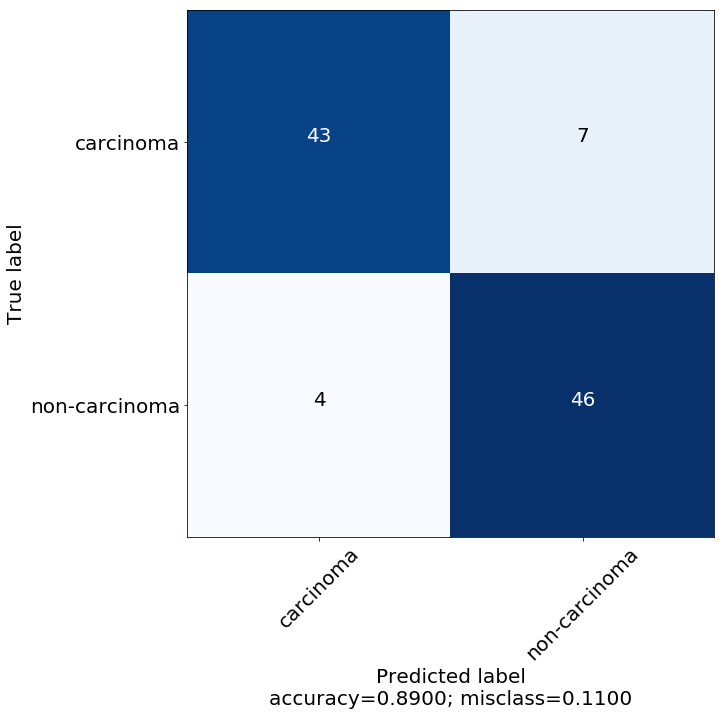

In [20]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = []

label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

for k,v in indexlabel.items():
    labels.append(v)

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')

In [21]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred=predictions
y_pred_probabilities=y_pred

# y_pred = np.argmax(y_pred,axis = 1) 
y_actual = y_true

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[43  7]
 [ 4 46]]
               precision    recall  f1-score   support

    carcinoma       0.91      0.86      0.89        50
non-carcinoma       0.87      0.92      0.89        50

  avg / total       0.89      0.89      0.89       100



In [22]:
total=sum(sum(cm))

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Sensitivity :  91.48936170212765
Specificity :  86.79245283018868


In [23]:
print('roc_auc_score = ' + str(roc_auc_score(predictions, y_true)))

roc_auc_score = 0.8914090726615816


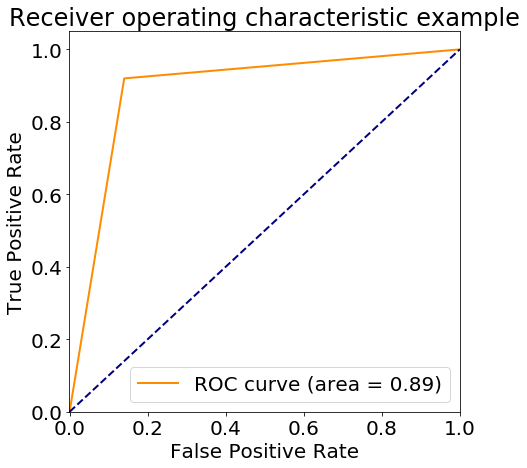

In [24]:
fpr, tpr, thresholds = roc_curve(y_true, predictions)
roc_auc = auc(fpr,tpr)

plt.figure(figsize=(7,7))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-.001, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [25]:
predict = model.predict_proba(test_data, batch_size=batch_size, verbose=1)

100/100 [==============================] - 0s 30us/step


In [26]:
from sklearn.preprocessing import label_binarize

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
y = label_binarize(test_labels, classes=[0, 1])
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], predict[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), predict.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [27]:
from scipy import interp
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

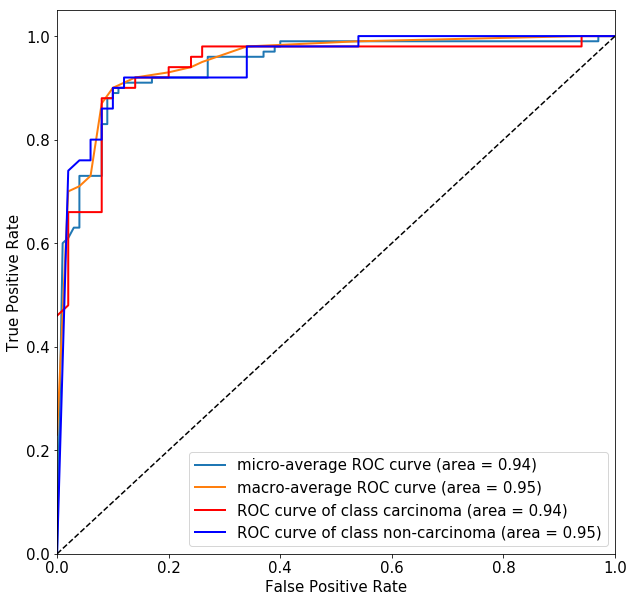

In [28]:
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 15})

from itertools import cycle
classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)
    

plt.figure(figsize=(10, 10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),linewidth=2)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         linewidth=2)
plot_name = 'no variation'
colors = cycle(['red','blue','green','yellow','orange', 'aqua', 'cornflowerblue'])

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classnames[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [29]:
tn, fp, fn, tp = cm.ravel()

In [30]:
print("Accuracy:",(tp+tn)/(tp+tn+fp+fn))
print("Precision:",(tp/(tp+fp)))
print("Recall:",(tp/(tp+fn)))
print("tp:", tp) 
print("fp:", fp) 
print("tn:",tn) 
print("fn:",fn)

Accuracy: 0.89
Precision: 0.8679245283018868
Recall: 0.92
tp: 46
fp: 7
tn: 43
fn: 4


In [31]:
print('F1 score:', f1_score(y_true, y_pred))

F1 score: 0.8932038834951457


In [32]:
recall = (tp/(tp+fn))
precision=(tp/(tp+fp))

f1 = 2 / ( (1/recall) + (1 / precision))
print('F1 score:', f1)

F1 score: 0.8932038834951458


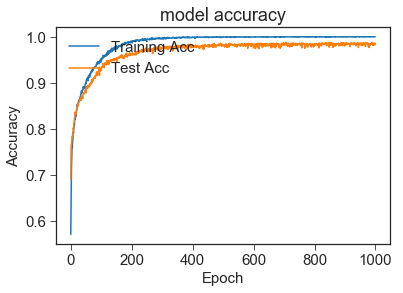

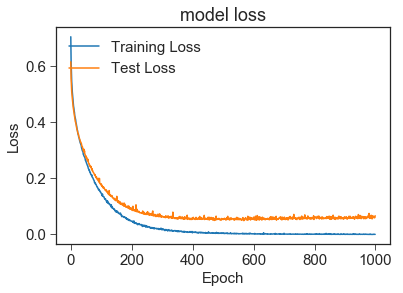

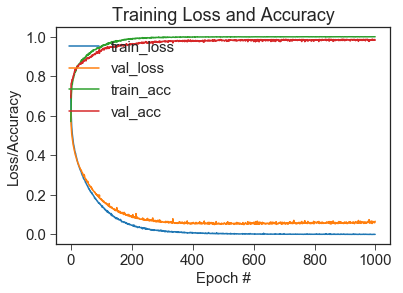

In [33]:
plt.style.use("seaborn-ticks")

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")